In [1]:
import numpy as np
from gwbench import snr
from gwbench import waveform as wfc
from gwbench import injections
from gwbench import network
from gwbench import basic_relations as br

from pycbc import conversions as conv

from astropy.cosmology import Planck18, z_at_value

import gwbench_network_funcs as gwnet

from scipy.optimize import minimize
from scipy import integrate
import lalsimulation as ls
import lal

from pycbc.types import FrequencySeries
from pycbc.filter import match
from pycbc.filter import matchedfilter
import pycbc.filter as fil

from pycbc import types, fft, waveform

import matplotlib.pyplot as plt

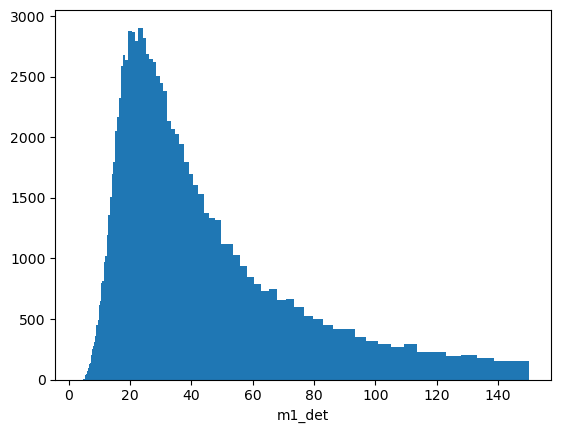

In [2]:
input_file = './smooth_powerlaw_pop.npz'
with np.load(input_file, mmap_mode='r') as binaries:
    Mcs = np.array(binaries['Mcs'])
    etas = np.array(binaries['etas'])
    chi1z = np.array(binaries['chi1z'])
    chi2z = np.array(binaries['chi2z'])
    DLs = np.array(binaries['DLs'])
    iotas = np.array(binaries['iotas'])
    ras = np.array(binaries['ras'])
    decs = np.array(binaries['decs'])
    psis = np.array(binaries['psis'])

m1s = conv.mass1_from_mchirp_eta(Mcs, etas)
mtotals = conv.mtotal_from_mchirp_eta(Mcs, etas)
f_highs = np.round(4*br.f_isco_Msolar(mtotals))


plt.hist(m1s, bins = np.geomspace(3.0, 150.0, 100))
plt.xlabel('m1_det')
plt.show()


In [3]:
def cutler_vallisneri_overlap_vec(del_hf, delta_hf, psd, freqs):
    return np.array([ inner_prod_simps(del_hf[deriv], delta_hf, psd, freqs) for deriv in del_hf ])

def inner_prod_simps_normed(h1, h2, Sn, f, h1_norm = None, h2_norm=None):
    if h1_norm is None:
        h1_norm = 4*np.real(integrate.simpson(y= h1*np.conjugate(h1) / Sn, x=f))
    if h2_norm is None:
        h2_norm = 4*np.real(integrate.simpson(y= h2*np.conjugate(h2) / Sn, x=f))
    return  2*np.real(integrate.simpson(y= (h1*np.conjugate(h2) + h2*np.conjugate(h1)) / Sn, x=f)) / (np.sqrt(h1_norm * h2_norm))

def inner_prod_simps(h1, h2, Sn, f):
    return  2*np.real(integrate.simpson(y= (h1*np.conjugate(h2) + h2*np.conjugate(h1)) / Sn, x=f))


# Optimize Phic, tc using Matched Filter

In [9]:
binary_i = 47519 # 'Pessimistic' Binary
offset = 0

net_key = '3G'
approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

inj_params = {
    'Mc':    Mcs[binary_i+offset],
    'eta':   etas[binary_i+offset],
    'chi1x': 0.,
    'chi2x': 0.,
    'chi1y': 0.,
    'chi2y': 0.,
    'chi1z': chi1z[binary_i+offset],
    'chi2z': chi2z[binary_i+offset],
    'DL':    DLs[binary_i+offset],
    'tc':    0,
    'phic':  0,
    'iota':  iotas[binary_i+offset],
    'ra':    ras[binary_i+offset],
    'dec':   decs[binary_i+offset],
    'psi':   psis[binary_i+offset],
    'gmst0': 0,
    'hybr': 0.0
    } 


net_true = gwnet.get_network_response(inj_params=inj_params, f_max=f_highs[binary_i+offset], approximant=approx1, network_key=net_key, calc_detector_responses=True, calc_derivs=False, calc_fisher=False)

net_ap = gwnet.get_network_response(inj_params=inj_params, f_max=f_highs[binary_i+offset], approximant=approx2, network_key=net_key, calc_detector_responses=True, calc_derivs=True, calc_fisher=True)

2024-01-11 12:15:26,350 - Network - INFO : Polarizations calculated.
2024-01-11 12:15:26,405 - Network - INFO : PSDs loaded.
2024-01-11 12:15:26,408 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 12:15:26,424 - Network - INFO : Detector responses calculated.
2024-01-11 12:15:26,427 - Network - INFO : SNRs calculated.
2024-01-11 12:15:26,430 - Network - INFO : Polarizations calculated.
2024-01-11 12:15:26,431 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-11 12:15:26,434 - Network - INFO : Polarizations calculated.
2024-01-11 12:15:27,332 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-11 12:15:27,405 - Network - INFO : PSDs loaded.
2024-01-11 12:15:27,408 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 12:15:27,419 - Network - INFO : Detector responses calculated.
2024-01-11 12:15:27,420 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-11 12:15:27,420 - Network - INFO

2024-01-11 12:15:31,303 - Network - INFO : Polarizations calculated.
2024-01-11 12:15:31,411 - Network - INFO : PSDs loaded.
2024-01-11 12:15:31,413 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 12:15:31,417 - Network - INFO : Detector responses calculated.
2024-01-11 12:15:31,419 - Network - INFO : SNRs calculated.


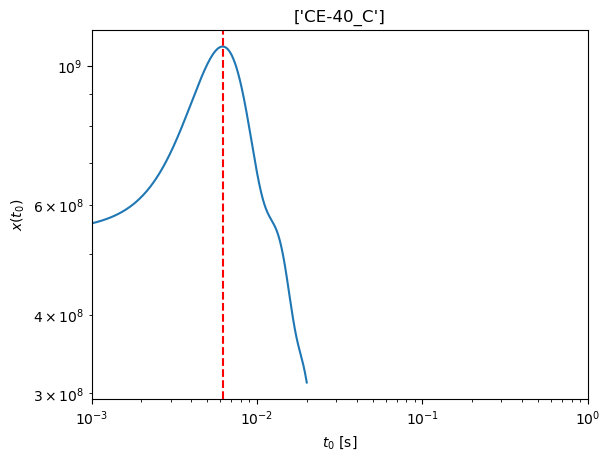

time shift: 0.0061994
phase shift: -2.181770268274838
Inner product:
0.9997479969549381


2024-01-11 12:15:32,136 - Network - INFO : Polarizations calculated.
2024-01-11 12:15:32,144 - Network - INFO : PSDs loaded.
2024-01-11 12:15:32,145 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 12:15:32,149 - Network - INFO : Detector responses calculated.
2024-01-11 12:15:32,150 - Network - INFO : SNRs calculated.


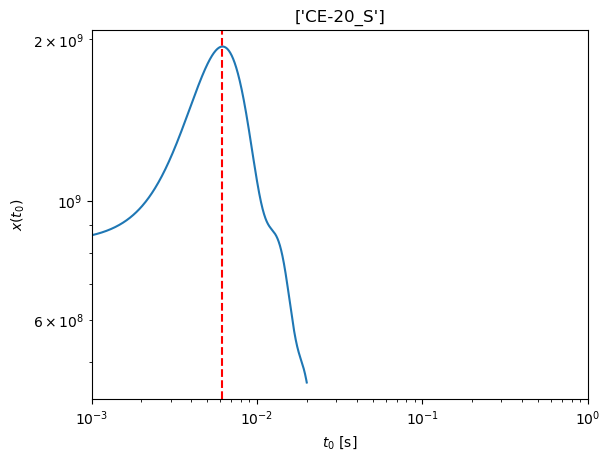

time shift: 0.0061795999999999995
phase shift: -2.187999633723762
Inner product:
0.9996965721260552


2024-01-11 12:15:33,014 - Network - INFO : Polarizations calculated.
2024-01-11 12:15:33,029 - Network - INFO : PSDs loaded.
2024-01-11 12:15:33,031 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 12:15:33,034 - Network - INFO : Detector responses calculated.
2024-01-11 12:15:33,035 - Network - INFO : SNRs calculated.


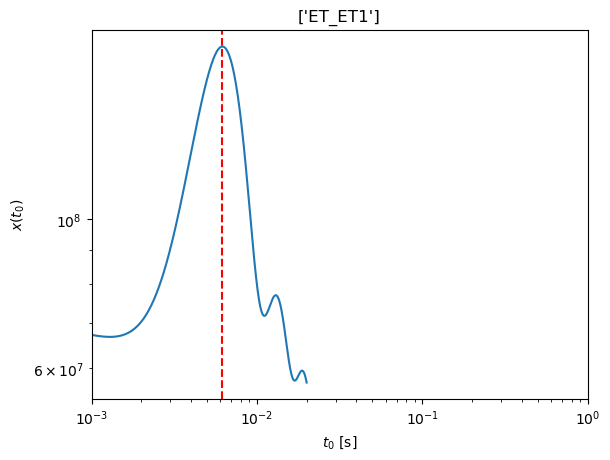

time shift: 0.0061795999999999995
phase shift: -2.1835994361521243
Inner product:
0.9996594344787033


2024-01-11 12:15:33,821 - Network - INFO : Polarizations calculated.
2024-01-11 12:15:33,835 - Network - INFO : PSDs loaded.
2024-01-11 12:15:33,837 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 12:15:33,841 - Network - INFO : Detector responses calculated.
2024-01-11 12:15:33,843 - Network - INFO : SNRs calculated.


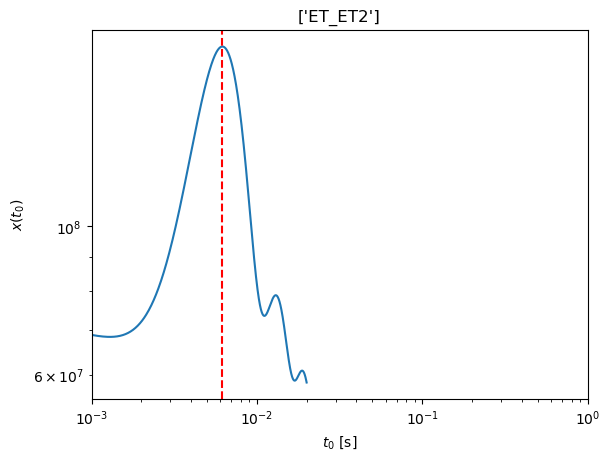

time shift: 0.0061795999999999995
phase shift: -2.1835994361521243
Inner product:
0.9996594344787033


2024-01-11 12:15:34,507 - Network - INFO : Polarizations calculated.
2024-01-11 12:15:34,522 - Network - INFO : PSDs loaded.
2024-01-11 12:15:34,523 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 12:15:34,527 - Network - INFO : Detector responses calculated.
2024-01-11 12:15:34,529 - Network - INFO : SNRs calculated.


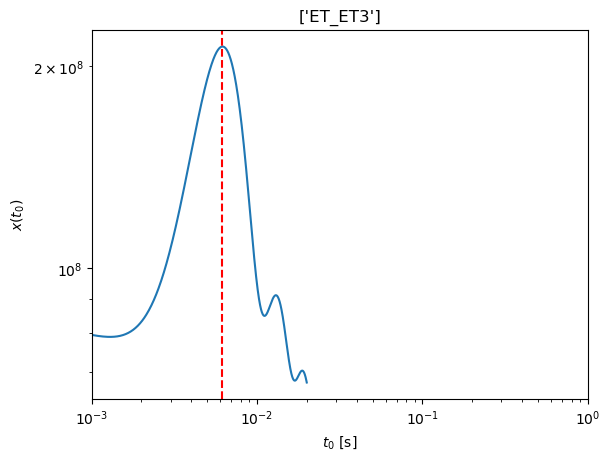

time shift: 0.0061795999999999995
phase shift: -2.1835994361521243
Inner product:
0.9996594344787031


In [10]:
overlap_vecs_network = np.zeros((len(net_ap.detectors), len(net_ap.deriv_variables)))

# Limit the time window to precisely search for t_0
time_arr_d = np.linspace(0.0002, 0.02, 1001)
# time_arr_d = np.linspace(-0.02, 0.02, 1001)


for d in range(len(net_ap.detectors)):

    ## set up initial waveforms
    h1 = net_true.detectors[d].hf
    h2 = net_ap.detectors[d].hf
    Sn = net_ap.detectors[d].psd
    f = net_ap.detectors[d].f
    network_spec_d = [net_ap.detectors[d].det_key]

    # Set up Matched Filter 
    x_t0_re_d = np.zeros(len(time_arr_d))
    x_t0_im_d = np.zeros(len(time_arr_d))

    for i_t in range(len(time_arr_d)):
        t0 = time_arr_d[i_t]
        x_t0_d = 4*(integrate.simpson(h1 * np.conjugate(h2) * np.exp(2*np.pi*1j*f*t0)/ Sn, x=f))
        x_t0_re_d[i_t] = np.real(x_t0_d)
        x_t0_im_d[i_t] = np.imag(x_t0_d)

    # Find time that maximizes overlap
    max_idx = np.argmax(x_t0_re_d**2 + x_t0_im_d**2)
    time_shift_d = time_arr_d[max_idx]
    phase_shift_d = np.unwrap(np.angle(x_t0_re_d + 1j*x_t0_im_d))[max_idx]

    inj_params_opt_d = inj_params.copy()
    inj_params_opt_d['tc'] = time_shift_d
    inj_params_opt_d['phic'] = phase_shift_d 

    net_tr_opt_d = gwnet.get_network_response(inj_params=inj_params_opt_d, f_max=f_highs[binary_i+offset], approximant=approx1, network_spec=network_spec_d, calc_detector_responses=True, calc_derivs=False, calc_fisher=False)

    #  ## Sanity Checks to make sure the correct phase and time shifts are being applied
    plt.title(network_spec_d)
    plt.plot(time_arr_d, x_t0_re_d**2 + x_t0_im_d**2)
    plt.axvline(x=time_shift_d, ls='--', c='r')
    plt.xlabel('$t_0$ [s]')
    plt.ylabel("$x(t_0)$")
    plt.loglog()
    plt.xlim(1e-3, 1e0)
    plt.show()
    print("time shift:", time_shift_d)
    print("phase shift:", phase_shift_d)
    print("Inner product:")
    # print(net_ap.detectors[d].f.shape)
    # print(net_tr_opt_d.detectors[0].f.shape)
    print(inner_prod_simps_normed(net_tr_opt_d.detectors[0].hf, h2, Sn, f))

    ## Compute CV overlap vector for this detector
    delta_hf = net_tr_opt_d.detectors[0].hf - h2
    overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap.detectors[d].del_hf, delta_hf, Sn, f)

cv_bias_opt = np.matmul(net_ap.cov, np.sum(overlap_vecs_network, axis=0))
cv_bias_opt = np.array(cv_bias_opt.tolist()[0])

Mc: -4.970 sigma
eta: -1.318 sigma
chi1z: 3.656 sigma
chi2z: -3.658 sigma
DL: 0.239 sigma
tc: -3.251 sigma
phic: -2.579 sigma
iota: -0.502 sigma
ra: 0.576 sigma
dec: 0.558 sigma
psi: -0.987 sigma


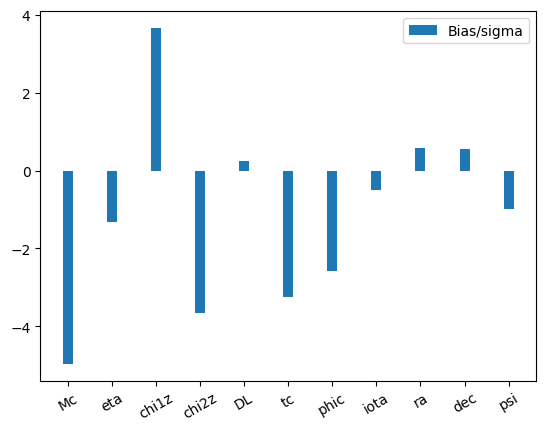

In [11]:
cv_bias_sigma = np.zeros(len(cv_bias_opt))

for i, var in enumerate(net_ap.deriv_variables):
    cv_bias_sigma[i] = cv_bias_opt[i]/net_ap.errs[var]
    print(f"{net_ap.deriv_variables[i]}: {cv_bias_opt[i]/net_ap.errs[var]:.3f} sigma")


bias1 = cv_bias_sigma

x = np.linspace(0, len(bias1), len(bias1))

width = 0.25
plt.bar(x, bias1, width=width, label='Bias/sigma')

plt.xticks(x, net_ap.deriv_variables, rotation=30)

plt.legend()
plt.show()


# Hybrid Waveform Test

In [5]:
binary_i = 47519 # 'Pessimistic' Binary
offset = 0

net_key = '3G'
approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'



inj_params_hyb = {
    'Mc':    Mcs[binary_i+offset],
    'eta':   etas[binary_i+offset],
    'chi1x': 0.,
    'chi2x': 0.,
    'chi1y': 0.,
    'chi2y': 0.,
    'chi1z': chi1z[binary_i+offset],
    'chi2z': chi2z[binary_i+offset],
    'DL':    DLs[binary_i+offset],
    'tc':    0,
    'phic':  0,
    'iota':  iotas[binary_i+offset],
    'ra':    ras[binary_i+offset],
    'dec':   decs[binary_i+offset],
    'psi':   psis[binary_i+offset],
    'gmst0': 0,
    'hybr': 0.01
    } 


net_true = gwnet.get_network_response(inj_params=inj_params_hyb, f_max=f_highs[binary_i+offset], approximant=approx1, network_key=net_key, calc_detector_responses=True, calc_derivs=False, calc_fisher=False)


net_ap_hyb = gwnet.get_hybrid_network_response(inj_params=inj_params_hyb, f_max=f_highs[binary_i+offset], 
    approximant1=approx1, approximant2=approx2, 
    network_key=net_key, calc_detector_responses=True, calc_derivs=True, calc_fisher=True)

2024-01-11 12:14:44,396 - Network - INFO : Polarizations calculated.
2024-01-11 12:14:44,448 - Network - INFO : PSDs loaded.
2024-01-11 12:14:44,451 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 12:14:44,465 - Network - INFO : Detector responses calculated.
2024-01-11 12:14:44,468 - Network - INFO : SNRs calculated.
2024-01-11 12:14:44,474 - Network - INFO : Polarizations calculated.
2024-01-11 12:14:44,475 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-11 12:14:44,482 - Network - INFO : Polarizations calculated.
2024-01-11 12:14:45,312 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-11 12:14:45,360 - Network - INFO : PSDs loaded.
2024-01-11 12:14:45,363 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 12:14:45,392 - Network - INFO : Detector responses calculated.
2024-01-11 12:14:45,393 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-11 12:14:45,393 - Network - INFO

2024-01-11 12:15:08,077 - Network - INFO : Polarizations calculated.
2024-01-11 12:15:08,084 - Network - INFO : PSDs loaded.
2024-01-11 12:15:08,085 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 12:15:08,089 - Network - INFO : Detector responses calculated.
2024-01-11 12:15:08,090 - Network - INFO : SNRs calculated.


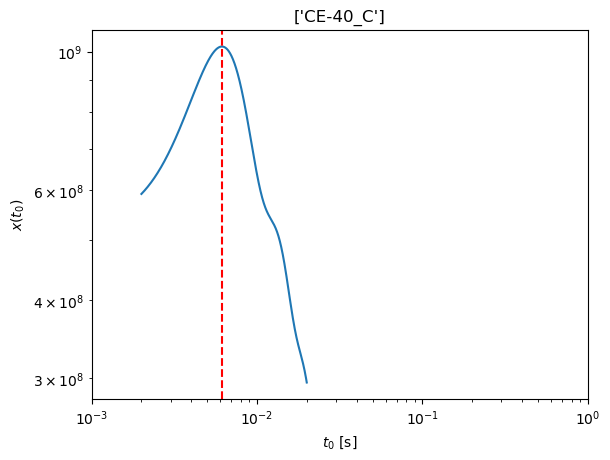

time shift: 0.0061400000000000005
phase shift: -2.1705260818828482
Inner product:
0.9997525579289385


2024-01-11 12:15:08,853 - Network - INFO : Polarizations calculated.
2024-01-11 12:15:08,861 - Network - INFO : PSDs loaded.
2024-01-11 12:15:08,862 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 12:15:08,866 - Network - INFO : Detector responses calculated.
2024-01-11 12:15:08,867 - Network - INFO : SNRs calculated.


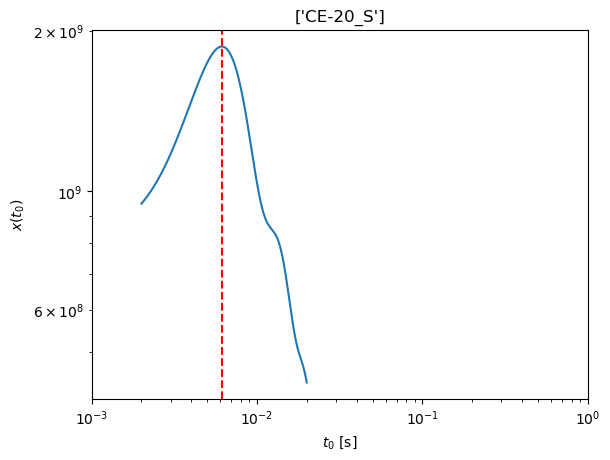

time shift: 0.006122
phase shift: -2.1704140876347275
Inner product:
0.9997041918526445


2024-01-11 12:15:09,544 - Network - INFO : Polarizations calculated.
2024-01-11 12:15:09,560 - Network - INFO : PSDs loaded.
2024-01-11 12:15:09,561 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 12:15:09,565 - Network - INFO : Detector responses calculated.
2024-01-11 12:15:09,567 - Network - INFO : SNRs calculated.


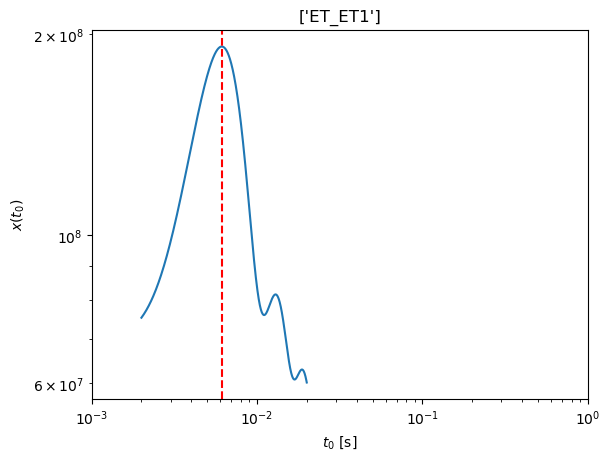

time shift: 0.006122
phase shift: -2.2034938438434373
Inner product:
0.9996677495608483


2024-01-11 12:15:10,247 - Network - INFO : Polarizations calculated.
2024-01-11 12:15:10,262 - Network - INFO : PSDs loaded.
2024-01-11 12:15:10,264 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 12:15:10,268 - Network - INFO : Detector responses calculated.
2024-01-11 12:15:10,270 - Network - INFO : SNRs calculated.


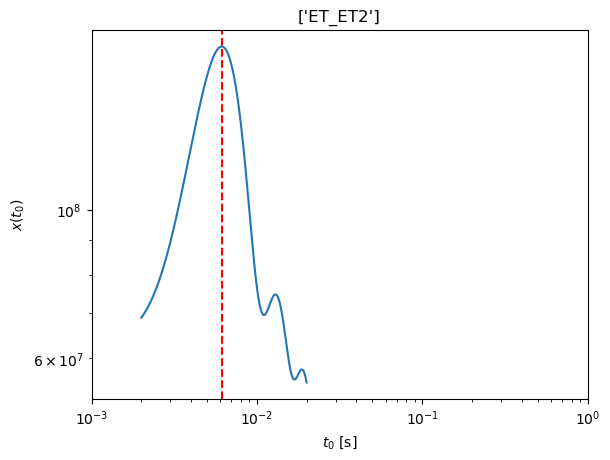

time shift: 0.006122
phase shift: -2.2097611632383267
Inner product:
0.9996677495608486


2024-01-11 12:15:10,935 - Network - INFO : Polarizations calculated.
2024-01-11 12:15:10,951 - Network - INFO : PSDs loaded.
2024-01-11 12:15:10,953 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 12:15:10,956 - Network - INFO : Detector responses calculated.
2024-01-11 12:15:10,958 - Network - INFO : SNRs calculated.


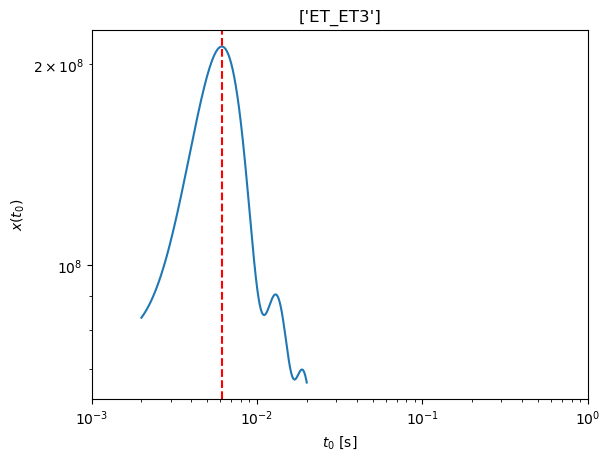

time shift: 0.006122
phase shift: -2.1608517686230715
Inner product:
0.9996677495608488


In [7]:
overlap_vecs_network = np.zeros((len(net_ap_hyb.detectors), len(net_ap_hyb.deriv_variables)))

# Limit the time window to precisely search for t_0
time_arr_d = np.linspace(0.002, 0.02, 1001)


for d in range(len(net_ap_hyb.detectors)):

    ## set up initial waveforms
    h1 = net_true.detectors[d].hf
    h2 = net_ap_hyb.detectors[d].hf
    Sn = net_ap_hyb.detectors[d].psd
    f = net_ap_hyb.detectors[d].f
    network_spec_d = [net_ap_hyb.detectors[d].det_key]

    # Set up Matched Filter 
    x_t0_re_d = np.zeros(len(time_arr_d))
    x_t0_im_d = np.zeros(len(time_arr_d))

    for i_t in range(len(time_arr_d)):
        t0 = time_arr_d[i_t]
        x_t0_d = 4*(integrate.simpson(h1 * np.conjugate(h2) * np.exp(2*np.pi*1j*f*t0)/ Sn, x=f))
        x_t0_re_d[i_t] = np.real(x_t0_d)
        x_t0_im_d[i_t] = np.imag(x_t0_d)

    # Find time that maximizes overlap
    max_idx = np.argmax(x_t0_re_d**2 + x_t0_im_d**2)
    time_shift_d = time_arr_d[max_idx]
    phase_shift_d = np.unwrap(np.angle(x_t0_re_d + 1j*x_t0_im_d))[max_idx]

    inj_params_opt_d = inj_params_hyb.copy()
    inj_params_opt_d['tc'] = time_shift_d
    inj_params_opt_d['phic'] = phase_shift_d 

    net_tr_opt_d = gwnet.get_network_response(inj_params=inj_params_opt_d, f_max=f_highs[binary_i+offset], 
    approximant=approx1,
    network_spec=network_spec_d, calc_detector_responses=True, calc_derivs=False, calc_fisher=False)

    #  ## Sanity Checks to make sure the correct phase and time shifts are being applied
    plt.title(network_spec_d)
    plt.plot(time_arr_d, x_t0_re_d**2 + x_t0_im_d**2)
    plt.axvline(x=time_shift_d, ls='--', c='r')
    plt.xlabel('$t_0$ [s]')
    plt.ylabel("$x(t_0)$")
    plt.loglog()
    plt.xlim(1e-3, 1e0)
    plt.show()
    print("time shift:", time_shift_d)
    print("phase shift:", phase_shift_d)
    print("Inner product:")
    print(inner_prod_simps_normed(net_tr_opt_d.detectors[0].hf, h2, Sn, f))

    ## Compute CV overlap vector for this detector
    delta_hf = net_tr_opt_d.detectors[0].hf - h2
    overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap_hyb.detectors[d].del_hf, delta_hf, Sn, f)

cv_bias_opt_hybr = np.matmul(net_ap_hyb.cov, np.sum(overlap_vecs_network, axis=0))
cv_bias_opt_hybr = np.array(cv_bias_opt_hybr.tolist()[0])

def: Mc: -4.970 sigma
hyb: Mc: -4.967 sigma

def: eta: -1.318 sigma
hyb: eta: -1.425 sigma

def: chi1z: 3.656 sigma
hyb: chi1z: 3.715 sigma

def: chi2z: -3.658 sigma
hyb: chi2z: -3.721 sigma

def: DL: 0.239 sigma
hyb: DL: 6.559 sigma

def: tc: -3.251 sigma
hyb: tc: -3.278 sigma

def: phic: -2.579 sigma
hyb: phic: -5.604 sigma

def: iota: -0.502 sigma
hyb: iota: -6.643 sigma

def: ra: 0.576 sigma
hyb: ra: -0.289 sigma

def: dec: 0.558 sigma
hyb: dec: -0.066 sigma

def: psi: -0.987 sigma
hyb: psi: -4.918 sigma



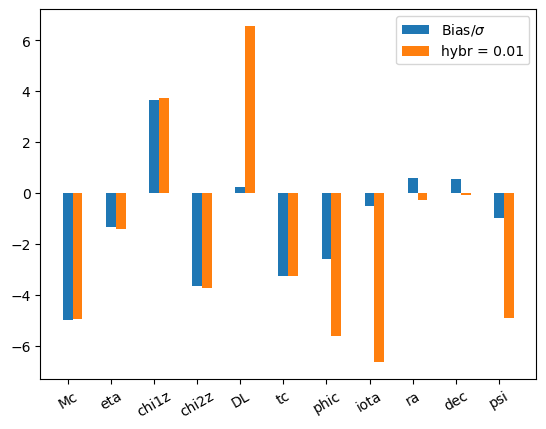

In [12]:
cv_bias_sigma = np.zeros(len(cv_bias_opt))
cv_bias_hybr_sigma = np.zeros(len(cv_bias_opt))

for i, var in enumerate(net_ap.deriv_variables):
    cv_bias_sigma[i] = cv_bias_opt[i]/net_ap.errs[var]
    cv_bias_hybr_sigma[i] = cv_bias_opt_hybr[i]/net_ap.errs[var]

    print(f"def: {net_ap.deriv_variables[i]}: {cv_bias_opt[i]/net_ap.errs[var]:.3f} sigma")
    print(f"hyb: {net_ap.deriv_variables[i]}: {cv_bias_opt_hybr[i]/net_ap.errs[var]:.3f} sigma")
    print()


bias1 = cv_bias_sigma
bias2 = cv_bias_hybr_sigma

x = np.linspace(0, len(bias1), len(bias1))

width = 0.25
plt.bar(x, bias1, width=width, label='Bias/$\sigma$')
plt.bar(x+width, bias2, width=width, label=f"hybr = {inj_params_hyb['hybr']}")

plt.xticks(x, net_ap.deriv_variables, rotation=30)

plt.legend()
plt.show()


## Bias vs Hybr

In [136]:
# binary_i = 47519 # 'Pessimistic' Binary
binary_i = 100 

offset = 0

net_key = '3G'
approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

inj_params = {
        'Mc':    Mcs[binary_i+offset],
        'eta':   etas[binary_i+offset],
        'chi1x': 0.,
        'chi2x': 0.,
        'chi1y': 0.,
        'chi2y': 0.,
        'chi1z': chi1z[binary_i+offset],
        'chi2z': chi2z[binary_i+offset],
        'DL':    DLs[binary_i+offset],
        'tc':    0,
        'phic':  0,
        'iota':  iotas[binary_i+offset],
        'ra':    ras[binary_i+offset],
        'dec':   decs[binary_i+offset],
        'psi':   psis[binary_i+offset],
        'gmst0': 0,
        'hybr': 0.0
        } 

net_true = gwnet.get_network_response(inj_params=inj_params, f_max=f_highs[binary_i+offset], approximant=approx1, network_key=net_key, calc_detector_responses=True, calc_derivs=False, calc_fisher=False)

2024-01-11 14:33:05,829 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:05,883 - Network - INFO : PSDs loaded.
2024-01-11 14:33:05,886 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:05,902 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:05,905 - Network - INFO : SNRs calculated.


In [137]:
hybr_range = [0.0, 0.3, 0.45, 0.65, 0.96, 0.98, 0.99, 0.9999, 1.0]
cv_bias_opt_hybr_all = np.zeros((len(hybr_range), len(cv_bias_opt)))
inner_prod_hybr_all = np.zeros(len(hybr_range))


for h, hybr in enumerate(hybr_range):
    print("hybr: ", hybr)

    inj_params_hyb = inj_params.copy()
    inj_params_hyb['hybr'] = hybr

    net_ap_hyb = gwnet.get_hybrid_network_response(inj_params=inj_params_hyb, f_max=f_highs[binary_i+offset], 
        approximant1=approx1, approximant2=approx2, 
        network_key=net_key, calc_detector_responses=True, calc_derivs=True, calc_fisher=True)
        

    # Find the CV Bias    
    overlap_vecs_network = np.zeros((len(net_ap_hyb.detectors), len(net_ap_hyb.deriv_variables)))
    # Limit the time window to precisely search for t_0
    time_arr_d = np.linspace(-0.01, 0.01, 1003)


    for d in range(len(net_ap_hyb.detectors)):

        ## set up initial waveforms
        h1 = net_true.detectors[d].hf
        h2 = net_ap_hyb.detectors[d].hf
        Sn = net_ap_hyb.detectors[d].psd
        f = net_ap_hyb.detectors[d].f
        network_spec_d = [net_ap_hyb.detectors[d].det_key]

        # Set up Matched Filter 
        x_t0_re_d = np.zeros(len(time_arr_d))
        x_t0_im_d = np.zeros(len(time_arr_d))

        for i_t in range(len(time_arr_d)):
            t0 = time_arr_d[i_t]
            x_t0_d = 4*(integrate.simpson(h1 * np.conjugate(h2) * np.exp(2*np.pi*1j*f*t0)/ Sn, x=f))
            x_t0_re_d[i_t] = np.real(x_t0_d)
            x_t0_im_d[i_t] = np.imag(x_t0_d)

        # Find time that maximizes overlap
        max_idx = np.argmax(x_t0_re_d**2 + x_t0_im_d**2)
        time_shift_d = time_arr_d[max_idx]
        phase_shift_d = np.unwrap(np.angle(x_t0_re_d + 1j*x_t0_im_d))[max_idx]

        inj_params_opt_d = inj_params.copy()
        inj_params_opt_d['tc'] = time_shift_d
        inj_params_opt_d['phic'] = phase_shift_d 

        net_tr_opt_d = gwnet.get_network_response(inj_params=inj_params_opt_d, f_max=f_highs[binary_i+offset], 
        approximant=approx1,
        network_spec=network_spec_d, calc_detector_responses=True, calc_derivs=False, calc_fisher=False)

        #  ## Sanity Checks to make sure the correct phase and time shifts are being applied
        # plt.title(network_spec_d)
        # plt.plot(time_arr_d, x_t0_re_d**2 + x_t0_im_d**2)
        # plt.axvline(x=time_shift_d, ls='--', c='r')
        # plt.xlabel('$t_0$ [s]')
        # plt.ylabel("$x(t_0)$")
        # plt.loglog()
        # plt.xlim(1e-3, 1e0)
        # plt.show()
        print("time shift:", time_shift_d)
        print("phase shift:", phase_shift_d)
        print("Inner product:")
        # print(net_ap_hyb.detectors[d].f.shape)
        # print(net_tr_opt_d.detectors[0].f.shape)
        print(inner_prod_simps_normed(net_tr_opt_d.detectors[0].hf, h2, Sn, f))

        if d==0:
            inner_prod_hybr_all[h] = inner_prod_simps_normed(net_tr_opt_d.detectors[0].hf, h2, Sn, f)
        ## Compute CV overlap vector for this detector
        delta_hf = net_tr_opt_d.detectors[0].hf - h2
        overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap_hyb.detectors[d].del_hf, delta_hf, Sn, f)

    cv_bias_opt_hybr = np.matmul(net_ap_hyb.cov, np.sum(overlap_vecs_network, axis=0))
    cv_bias_opt_hybr_all[h] = np.array(cv_bias_opt_hybr.tolist()[0])

2024-01-11 14:33:06,579 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:06,580 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-11 14:33:06,588 - Network - INFO : Polarizations calculated.


hybr:  0.0


2024-01-11 14:33:07,931 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-11 14:33:07,975 - Network - INFO : PSDs loaded.
2024-01-11 14:33:07,977 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:08,009 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:08,010 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-11 14:33:08,011 - Network - INFO :    CE-40_C
2024-01-11 14:33:08,901 - Network - INFO :    CE-20_S
2024-01-11 14:33:09,788 - Network - INFO :    ET_ET1
2024-01-11 14:33:10,690 - Network - INFO :    ET_ET2
2024-01-11 14:33:11,572 - Network - INFO :    ET_ET3
2024-01-11 14:33:12,449 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-11 14:33:12,451 - Network - INFO : SNRs calculated.
2024-01-11 14:33:12,452 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-11 14:33:12,452 - Network - INFO :    CE-40_C
2024-01-11 14:33:12,506 - Network - INFO :

time shift: 0.003652694610778443
phase shift: 4.017424415898837
Inner product:
0.999887239525484


2024-01-11 14:33:13,483 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:13,489 - Network - INFO : PSDs loaded.
2024-01-11 14:33:13,491 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:13,494 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:13,496 - Network - INFO : SNRs calculated.


time shift: 0.003652694610778443
phase shift: 4.016544777581694
Inner product:
0.9998566204012078


2024-01-11 14:33:13,964 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:13,978 - Network - INFO : PSDs loaded.
2024-01-11 14:33:13,979 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:13,983 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:13,984 - Network - INFO : SNRs calculated.


time shift: 0.003652694610778443
phase shift: 4.020069389840989
Inner product:
0.9997600946219771


2024-01-11 14:33:14,455 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:14,468 - Network - INFO : PSDs loaded.
2024-01-11 14:33:14,470 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:14,473 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:14,475 - Network - INFO : SNRs calculated.


time shift: 0.003652694610778443
phase shift: 4.020069389840989
Inner product:
0.9997600946219769


2024-01-11 14:33:14,943 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:14,955 - Network - INFO : PSDs loaded.
2024-01-11 14:33:14,957 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:14,961 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:14,963 - Network - INFO : SNRs calculated.
2024-01-11 14:33:14,975 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:14,975 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-11 14:33:14,982 - Network - INFO : Polarizations calculated.


time shift: 0.003652694610778443
phase shift: 4.020069389840989
Inner product:
0.9997600946219772
hybr:  0.3


2024-01-11 14:33:16,303 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-11 14:33:16,353 - Network - INFO : PSDs loaded.
2024-01-11 14:33:16,356 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:16,390 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:16,390 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-11 14:33:16,391 - Network - INFO :    CE-40_C
2024-01-11 14:33:17,518 - Network - INFO :    CE-20_S
2024-01-11 14:33:18,597 - Network - INFO :    ET_ET1
2024-01-11 14:33:19,699 - Network - INFO :    ET_ET2
2024-01-11 14:33:20,856 - Network - INFO :    ET_ET3
2024-01-11 14:33:21,966 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-11 14:33:21,969 - Network - INFO : SNRs calculated.
2024-01-11 14:33:21,970 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-11 14:33:21,970 - Network - INFO :    CE-40_C
2024-01-11 14:33:22,024 - Network - INFO :

time shift: 0.002554890219560879
phase shift: 4.6966732341606585
Inner product:
0.9999446176523906


2024-01-11 14:33:23,050 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:23,057 - Network - INFO : PSDs loaded.
2024-01-11 14:33:23,059 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:23,063 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:23,065 - Network - INFO : SNRs calculated.


time shift: 0.002554890219560879
phase shift: 4.695982447510795
Inner product:
0.9999301811080976


2024-01-11 14:33:23,657 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:23,670 - Network - INFO : PSDs loaded.
2024-01-11 14:33:23,671 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:23,675 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:23,677 - Network - INFO : SNRs calculated.


time shift: 0.002554890219560879
phase shift: -1.5847660268878498
Inner product:
0.9998828887418767


2024-01-11 14:33:24,286 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:24,299 - Network - INFO : PSDs loaded.
2024-01-11 14:33:24,301 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:24,305 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:24,306 - Network - INFO : SNRs calculated.


time shift: 0.002554890219560879
phase shift: -1.5847660268878494
Inner product:
0.9998828887418768


2024-01-11 14:33:24,934 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:24,950 - Network - INFO : PSDs loaded.
2024-01-11 14:33:24,951 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:24,957 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:24,959 - Network - INFO : SNRs calculated.
2024-01-11 14:33:24,973 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:24,975 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-11 14:33:24,983 - Network - INFO : Polarizations calculated.


time shift: 0.002554890219560879
phase shift: -1.5847660268878498
Inner product:
0.999882888741877
hybr:  0.45


2024-01-11 14:33:26,847 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-11 14:33:26,893 - Network - INFO : PSDs loaded.
2024-01-11 14:33:26,895 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:26,926 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:26,926 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-11 14:33:26,927 - Network - INFO :    CE-40_C
2024-01-11 14:33:28,110 - Network - INFO :    CE-20_S
2024-01-11 14:33:29,418 - Network - INFO :    ET_ET1
2024-01-11 14:33:30,721 - Network - INFO :    ET_ET2
2024-01-11 14:33:31,821 - Network - INFO :    ET_ET3
2024-01-11 14:33:32,945 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-11 14:33:32,948 - Network - INFO : SNRs calculated.
2024-01-11 14:33:32,948 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-11 14:33:32,949 - Network - INFO :    CE-40_C
2024-01-11 14:33:33,003 - Network - INFO :

time shift: 0.0020159680638722564
phase shift: -1.2445406222838769
Inner product:
0.9999635230194978


2024-01-11 14:33:33,985 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:33,992 - Network - INFO : PSDs loaded.
2024-01-11 14:33:33,993 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:33,997 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:33,998 - Network - INFO : SNRs calculated.


time shift: 0.0020159680638722564
phase shift: -1.2447757046716517
Inner product:
0.9999520323348399


2024-01-11 14:33:34,467 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:34,481 - Network - INFO : PSDs loaded.
2024-01-11 14:33:34,482 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:34,486 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:34,488 - Network - INFO : SNRs calculated.


time shift: 0.0020159680638722564
phase shift: -1.2427604315412109
Inner product:
0.9999206581973881


2024-01-11 14:33:35,020 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:35,034 - Network - INFO : PSDs loaded.
2024-01-11 14:33:35,035 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:35,039 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:35,041 - Network - INFO : SNRs calculated.


time shift: 0.0020159680638722564
phase shift: -1.2427604315412102
Inner product:
0.9999206581973881


2024-01-11 14:33:35,563 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:35,577 - Network - INFO : PSDs loaded.
2024-01-11 14:33:35,579 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:35,583 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:35,584 - Network - INFO : SNRs calculated.
2024-01-11 14:33:35,597 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:35,598 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-11 14:33:35,606 - Network - INFO : Polarizations calculated.


time shift: 0.0020159680638722564
phase shift: -1.2427604315412109
Inner product:
0.9999206581973885
hybr:  0.65


2024-01-11 14:33:37,645 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-11 14:33:37,698 - Network - INFO : PSDs loaded.
2024-01-11 14:33:37,701 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:37,740 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:37,741 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-11 14:33:37,742 - Network - INFO :    CE-40_C
2024-01-11 14:33:39,042 - Network - INFO :    CE-20_S
2024-01-11 14:33:40,226 - Network - INFO :    ET_ET1
2024-01-11 14:33:41,497 - Network - INFO :    ET_ET2
2024-01-11 14:33:42,594 - Network - INFO :    ET_ET3
2024-01-11 14:33:43,860 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-11 14:33:43,863 - Network - INFO : SNRs calculated.
2024-01-11 14:33:43,863 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-11 14:33:43,863 - Network - INFO :    CE-40_C
2024-01-11 14:33:43,917 - Network - INFO :

time shift: 0.0012774451097804403
phase shift: -0.7932625327460235
Inner product:
0.999986131580168


2024-01-11 14:33:44,921 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:44,927 - Network - INFO : PSDs loaded.
2024-01-11 14:33:44,929 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:44,933 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:44,934 - Network - INFO : SNRs calculated.


time shift: 0.0012774451097804403
phase shift: -0.7936097096874013
Inner product:
0.9999825216358365


2024-01-11 14:33:45,441 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:45,454 - Network - INFO : PSDs loaded.
2024-01-11 14:33:45,455 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:45,459 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:45,461 - Network - INFO : SNRs calculated.


time shift: 0.0012774451097804403
phase shift: -0.7923949493116251
Inner product:
0.9999706817475502


2024-01-11 14:33:46,039 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:46,052 - Network - INFO : PSDs loaded.
2024-01-11 14:33:46,053 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:46,058 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:46,059 - Network - INFO : SNRs calculated.


time shift: 0.0012774451097804403
phase shift: -0.7923949493116249
Inner product:
0.9999706817475501


2024-01-11 14:33:46,633 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:46,647 - Network - INFO : PSDs loaded.
2024-01-11 14:33:46,648 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:46,652 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:46,653 - Network - INFO : SNRs calculated.
2024-01-11 14:33:46,666 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:46,666 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-11 14:33:46,673 - Network - INFO : Polarizations calculated.


time shift: 0.0012774451097804403
phase shift: -0.7923949493116251
Inner product:
0.9999706817475503
hybr:  0.96


2024-01-11 14:33:48,425 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-11 14:33:48,471 - Network - INFO : PSDs loaded.
2024-01-11 14:33:48,473 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:48,503 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:48,504 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-11 14:33:48,505 - Network - INFO :    CE-40_C
2024-01-11 14:33:49,588 - Network - INFO :    CE-20_S
2024-01-11 14:33:50,678 - Network - INFO :    ET_ET1
2024-01-11 14:33:51,784 - Network - INFO :    ET_ET2
2024-01-11 14:33:52,884 - Network - INFO :    ET_ET3
2024-01-11 14:33:53,964 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-11 14:33:53,969 - Network - INFO : SNRs calculated.
2024-01-11 14:33:53,970 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-11 14:33:53,970 - Network - INFO :    CE-40_C
2024-01-11 14:33:54,028 - Network - INFO :

time shift: 0.00013972055888223506
phase shift: -0.09213361665239936
Inner product:
0.999998126667625


2024-01-11 14:33:55,012 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:55,018 - Network - INFO : PSDs loaded.
2024-01-11 14:33:55,019 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:55,023 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:55,024 - Network - INFO : SNRs calculated.


time shift: 0.00013972055888223506
phase shift: -0.09240008271570783
Inner product:
0.9999977295969483


2024-01-11 14:33:55,494 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:55,508 - Network - INFO : PSDs loaded.
2024-01-11 14:33:55,509 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:55,513 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:55,514 - Network - INFO : SNRs calculated.


time shift: 0.00013972055888223506
phase shift: -0.09233684178362435
Inner product:
0.9999962504232341


2024-01-11 14:33:56,021 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:56,113 - Network - INFO : PSDs loaded.
2024-01-11 14:33:56,114 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:56,119 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:56,121 - Network - INFO : SNRs calculated.


time shift: 0.00013972055888223506
phase shift: -0.09233684178362274
Inner product:
0.9999962504232344


2024-01-11 14:33:56,655 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:56,667 - Network - INFO : PSDs loaded.
2024-01-11 14:33:56,668 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:56,672 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:56,674 - Network - INFO : SNRs calculated.
2024-01-11 14:33:56,686 - Network - INFO : Polarizations calculated.
2024-01-11 14:33:56,687 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-11 14:33:56,694 - Network - INFO : Polarizations calculated.


time shift: 0.00013972055888223506
phase shift: -0.09233684178362435
Inner product:
0.9999962504232344
hybr:  0.98


2024-01-11 14:33:58,396 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-11 14:33:58,443 - Network - INFO : PSDs loaded.
2024-01-11 14:33:58,446 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:33:58,476 - Network - INFO : Detector responses calculated.
2024-01-11 14:33:58,476 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-11 14:33:58,477 - Network - INFO :    CE-40_C
2024-01-11 14:33:59,605 - Network - INFO :    CE-20_S
2024-01-11 14:34:00,884 - Network - INFO :    ET_ET1
2024-01-11 14:34:02,230 - Network - INFO :    ET_ET2
2024-01-11 14:34:03,452 - Network - INFO :    ET_ET3
2024-01-11 14:34:04,566 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-11 14:34:04,569 - Network - INFO : SNRs calculated.
2024-01-11 14:34:04,570 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-11 14:34:04,570 - Network - INFO :    CE-40_C
2024-01-11 14:34:04,623 - Network - INFO :

time shift: 7.984031936127817e-05
phase shift: -0.04372118611752023
Inner product:
0.9999980231182567


2024-01-11 14:34:05,610 - Network - INFO : Polarizations calculated.
2024-01-11 14:34:05,617 - Network - INFO : PSDs loaded.
2024-01-11 14:34:05,618 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:34:05,622 - Network - INFO : Detector responses calculated.
2024-01-11 14:34:05,623 - Network - INFO : SNRs calculated.


time shift: 7.984031936127817e-05
phase shift: -0.04349391612104521
Inner product:
0.9999974347476442


2024-01-11 14:34:06,091 - Network - INFO : Polarizations calculated.
2024-01-11 14:34:06,104 - Network - INFO : PSDs loaded.
2024-01-11 14:34:06,105 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:34:06,110 - Network - INFO : Detector responses calculated.
2024-01-11 14:34:06,111 - Network - INFO : SNRs calculated.


time shift: 7.984031936127817e-05
phase shift: -0.043342664725552815
Inner product:
0.9999958509375623


2024-01-11 14:34:06,643 - Network - INFO : Polarizations calculated.
2024-01-11 14:34:06,656 - Network - INFO : PSDs loaded.
2024-01-11 14:34:06,658 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:34:06,662 - Network - INFO : Detector responses calculated.
2024-01-11 14:34:06,664 - Network - INFO : SNRs calculated.


time shift: 7.984031936127817e-05
phase shift: -0.0433426647255515
Inner product:
0.9999958509375619


2024-01-11 14:34:07,136 - Network - INFO : Polarizations calculated.
2024-01-11 14:34:07,149 - Network - INFO : PSDs loaded.
2024-01-11 14:34:07,150 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:34:07,155 - Network - INFO : Detector responses calculated.
2024-01-11 14:34:07,156 - Network - INFO : SNRs calculated.
2024-01-11 14:34:07,169 - Network - INFO : Polarizations calculated.
2024-01-11 14:34:07,169 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-11 14:34:07,177 - Network - INFO : Polarizations calculated.


time shift: 7.984031936127817e-05
phase shift: -0.04334266472555279
Inner product:
0.999995850937562
hybr:  0.99


2024-01-11 14:34:08,894 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-11 14:34:08,943 - Network - INFO : PSDs loaded.
2024-01-11 14:34:08,945 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:34:08,976 - Network - INFO : Detector responses calculated.
2024-01-11 14:34:08,976 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-11 14:34:08,977 - Network - INFO :    CE-40_C
2024-01-11 14:34:10,122 - Network - INFO :    CE-20_S
2024-01-11 14:34:11,231 - Network - INFO :    ET_ET1
2024-01-11 14:34:12,368 - Network - INFO :    ET_ET2
2024-01-11 14:34:13,473 - Network - INFO :    ET_ET3
2024-01-11 14:34:14,611 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-11 14:34:14,614 - Network - INFO : SNRs calculated.
2024-01-11 14:34:14,615 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-11 14:34:14,615 - Network - INFO :    CE-40_C
2024-01-11 14:34:14,669 - Network - INFO :

time shift: 3.9920159680639083e-05
phase shift: -0.02186058597254737
Inner product:
0.999999505799856


2024-01-11 14:34:15,676 - Network - INFO : Polarizations calculated.
2024-01-11 14:34:15,683 - Network - INFO : PSDs loaded.
2024-01-11 14:34:15,684 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:34:15,688 - Network - INFO : Detector responses calculated.
2024-01-11 14:34:15,690 - Network - INFO : SNRs calculated.


time shift: 3.9920159680639083e-05
phase shift: -0.021746951520658503
Inner product:
0.9999993587179354


2024-01-11 14:34:16,260 - Network - INFO : Polarizations calculated.
2024-01-11 14:34:16,274 - Network - INFO : PSDs loaded.
2024-01-11 14:34:16,275 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:34:16,280 - Network - INFO : Detector responses calculated.
2024-01-11 14:34:16,282 - Network - INFO : SNRs calculated.


time shift: 3.9920159680639083e-05
phase shift: -0.021671332601048955
Inner product:
0.9999989627952284


2024-01-11 14:34:16,886 - Network - INFO : Polarizations calculated.
2024-01-11 14:34:16,900 - Network - INFO : PSDs loaded.
2024-01-11 14:34:16,901 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:34:16,906 - Network - INFO : Detector responses calculated.
2024-01-11 14:34:16,907 - Network - INFO : SNRs calculated.


time shift: 3.9920159680639083e-05
phase shift: -0.021671332601047477
Inner product:
0.9999989627952287


2024-01-11 14:34:17,472 - Network - INFO : Polarizations calculated.
2024-01-11 14:34:17,486 - Network - INFO : PSDs loaded.
2024-01-11 14:34:17,487 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:34:17,491 - Network - INFO : Detector responses calculated.
2024-01-11 14:34:17,492 - Network - INFO : SNRs calculated.
2024-01-11 14:34:17,505 - Network - INFO : Polarizations calculated.
2024-01-11 14:34:17,505 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-11 14:34:17,513 - Network - INFO : Polarizations calculated.


time shift: 3.9920159680639083e-05
phase shift: -0.021671332601048948
Inner product:
0.9999989627952283
hybr:  0.9999


2024-01-11 14:34:19,252 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-11 14:34:19,298 - Network - INFO : PSDs loaded.
2024-01-11 14:34:19,300 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:34:19,330 - Network - INFO : Detector responses calculated.
2024-01-11 14:34:19,331 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-11 14:34:19,332 - Network - INFO :    CE-40_C
2024-01-11 14:34:20,457 - Network - INFO :    CE-20_S
2024-01-11 14:34:21,556 - Network - INFO :    ET_ET1
2024-01-11 14:34:22,681 - Network - INFO :    ET_ET2
2024-01-11 14:34:23,811 - Network - INFO :    ET_ET3
2024-01-11 14:34:24,966 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-11 14:34:24,970 - Network - INFO : SNRs calculated.
2024-01-11 14:34:24,971 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-11 14:34:24,971 - Network - INFO :    CE-40_C
2024-01-11 14:34:25,027 - Network - INFO :

time shift: 0.0
phase shift: -0.0003124349727021055
Inner product:
0.9999999944246141


2024-01-11 14:34:26,036 - Network - INFO : Polarizations calculated.
2024-01-11 14:34:26,042 - Network - INFO : PSDs loaded.
2024-01-11 14:34:26,043 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:34:26,047 - Network - INFO : Detector responses calculated.
2024-01-11 14:34:26,048 - Network - INFO : SNRs calculated.


time shift: 0.0
phase shift: -0.00032571917122382156
Inner product:
0.9999999929410448


2024-01-11 14:34:26,551 - Network - INFO : Polarizations calculated.
2024-01-11 14:34:26,564 - Network - INFO : PSDs loaded.
2024-01-11 14:34:26,566 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:34:26,570 - Network - INFO : Detector responses calculated.
2024-01-11 14:34:26,572 - Network - INFO : SNRs calculated.


time shift: 0.0
phase shift: -0.0003297473230054514
Inner product:
0.9999999885154008


2024-01-11 14:34:27,072 - Network - INFO : Polarizations calculated.
2024-01-11 14:34:27,085 - Network - INFO : PSDs loaded.
2024-01-11 14:34:27,087 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:34:27,091 - Network - INFO : Detector responses calculated.
2024-01-11 14:34:27,092 - Network - INFO : SNRs calculated.


time shift: 0.0
phase shift: -0.0003297473230040533
Inner product:
0.9999999885154006


2024-01-11 14:34:27,605 - Network - INFO : Polarizations calculated.
2024-01-11 14:34:27,618 - Network - INFO : PSDs loaded.
2024-01-11 14:34:27,619 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:34:27,623 - Network - INFO : Detector responses calculated.
2024-01-11 14:34:27,624 - Network - INFO : SNRs calculated.
2024-01-11 14:34:27,637 - Network - INFO : Polarizations calculated.
2024-01-11 14:34:27,637 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-11 14:34:27,645 - Network - INFO : Polarizations calculated.


time shift: 0.0
phase shift: -0.0003297473230054437
Inner product:
0.9999999885154006
hybr:  1.0


2024-01-11 14:34:29,400 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-11 14:34:29,445 - Network - INFO : PSDs loaded.
2024-01-11 14:34:29,448 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:34:29,479 - Network - INFO : Detector responses calculated.
2024-01-11 14:34:29,479 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-11 14:34:29,480 - Network - INFO :    CE-40_C
2024-01-11 14:34:30,569 - Network - INFO :    CE-20_S
2024-01-11 14:34:31,653 - Network - INFO :    ET_ET1
2024-01-11 14:34:32,755 - Network - INFO :    ET_ET2
2024-01-11 14:34:33,844 - Network - INFO :    ET_ET3
2024-01-11 14:34:34,960 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-11 14:34:34,963 - Network - INFO : SNRs calculated.
2024-01-11 14:34:34,963 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-11 14:34:34,964 - Network - INFO :    CE-40_C
2024-01-11 14:34:35,017 - Network - INFO :

time shift: 0.0
phase shift: -8.111462416181536e-14
Inner product:
0.9999999999999999


2024-01-11 14:34:35,999 - Network - INFO : Polarizations calculated.
2024-01-11 14:34:36,006 - Network - INFO : PSDs loaded.
2024-01-11 14:34:36,007 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:34:36,011 - Network - INFO : Detector responses calculated.
2024-01-11 14:34:36,012 - Network - INFO : SNRs calculated.


time shift: 0.0
phase shift: -9.087326431605317e-14
Inner product:
1.0


2024-01-11 14:34:36,483 - Network - INFO : Polarizations calculated.
2024-01-11 14:34:36,496 - Network - INFO : PSDs loaded.
2024-01-11 14:34:36,498 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:34:36,501 - Network - INFO : Detector responses calculated.
2024-01-11 14:34:36,503 - Network - INFO : SNRs calculated.


time shift: 0.0
phase shift: -6.526735875852406e-14
Inner product:
1.0


2024-01-11 14:34:37,007 - Network - INFO : Polarizations calculated.
2024-01-11 14:34:37,020 - Network - INFO : PSDs loaded.
2024-01-11 14:34:37,022 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:34:37,026 - Network - INFO : Detector responses calculated.
2024-01-11 14:34:37,027 - Network - INFO : SNRs calculated.


time shift: 0.0
phase shift: -6.374646318923942e-14
Inner product:
1.0


2024-01-11 14:34:37,537 - Network - INFO : Polarizations calculated.
2024-01-11 14:34:37,550 - Network - INFO : PSDs loaded.
2024-01-11 14:34:37,552 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:34:37,556 - Network - INFO : Detector responses calculated.
2024-01-11 14:34:37,557 - Network - INFO : SNRs calculated.


time shift: 0.0
phase shift: -6.525980917875046e-14
Inner product:
1.0


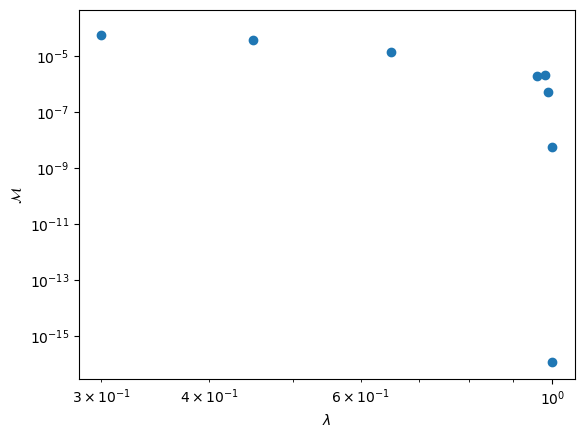

In [138]:
plt.scatter(hybr_range, 1-inner_prod_hybr_all)

plt.xlabel('$\lambda$')
plt.ylabel('$\mathcal{M}$')
           
plt.loglog()
plt.show()

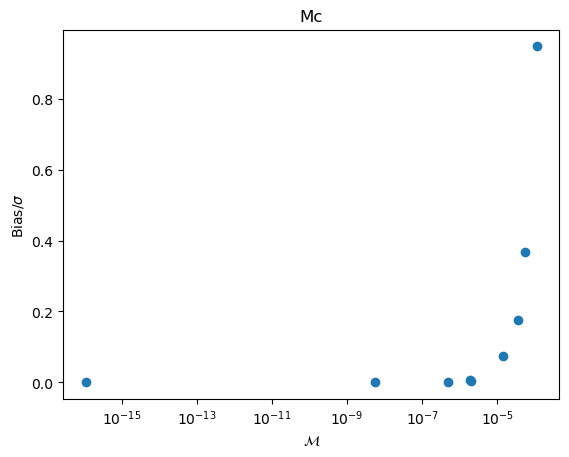

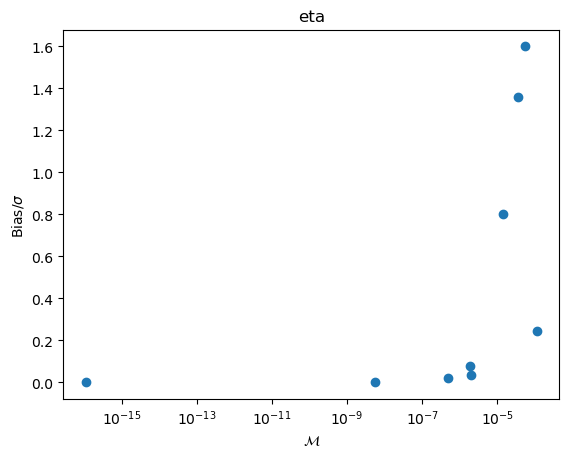

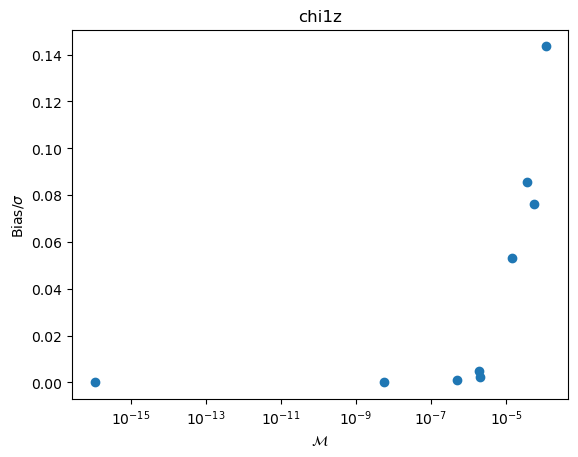

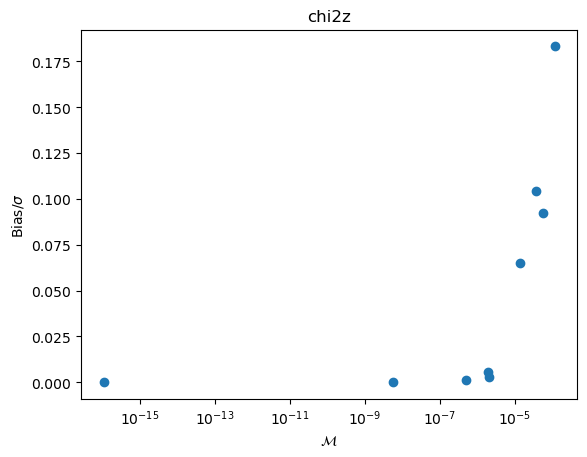

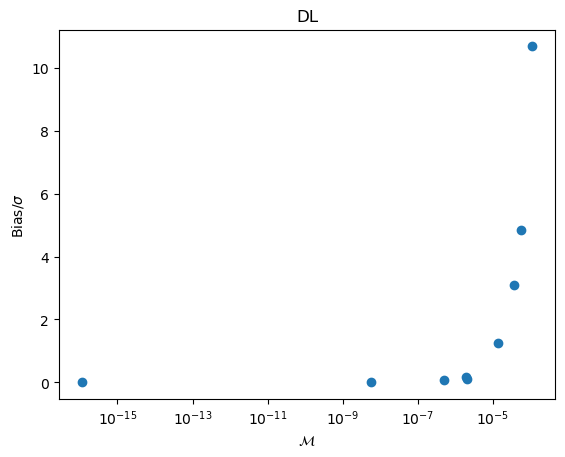

In [139]:
params = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL']
for i, var in enumerate(params):

    plt.title(var)
    plt.scatter(1-inner_prod_hybr_all, np.abs(cv_bias_opt_hybr_all[:,i]/net_ap.errs[var]))
    
    plt.semilogx()
    plt.xlabel('$\mathcal{M}$')
    plt.ylabel('Bias/$\sigma$')
    plt.show()


The phase shift for hybr 0.999 is non-negligible, which leads to wild DL biases. Maybe I should omit all extrinsic parameters from the accuracy requirement discussion?

# Plot hybr waveforms in time domain

In [116]:
binary_i = 47519 # 'Pessimistic' Binary
offset = 0

net_key = '3G'
approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

inj_params = {
        'Mc':    Mcs[binary_i+offset],
        'eta':   etas[binary_i+offset],
        'chi1x': 0.,
        'chi2x': 0.,
        'chi1y': 0.,
        'chi2y': 0.,
        'chi1z': chi1z[binary_i+offset],
        'chi2z': chi2z[binary_i+offset],
        'DL':    DLs[binary_i+offset],
        'tc':    0,
        'phic':  0,
        'iota':  iotas[binary_i+offset],
        'ra':    ras[binary_i+offset],
        'dec':   decs[binary_i+offset],
        'psi':   psis[binary_i+offset],
        'gmst0': 0,
        'hybr': 0.0
        } 

net_true = gwnet.get_network_response(inj_params=inj_params, f_max=f_highs[binary_i+offset], approximant=approx1, network_key=net_key, calc_detector_responses=True, calc_derivs=False, calc_fisher=False)

2024-01-11 14:17:52,220 - Network - INFO : Polarizations calculated.
2024-01-11 14:17:52,268 - Network - INFO : PSDs loaded.
2024-01-11 14:17:52,270 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:17:52,284 - Network - INFO : Detector responses calculated.
2024-01-11 14:17:52,286 - Network - INFO : SNRs calculated.


2024-01-11 14:28:38,014 - Network - INFO : Polarizations calculated.


2024-01-11 14:28:38,067 - Network - INFO : PSDs loaded.
2024-01-11 14:28:38,070 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:28:38,099 - Network - INFO : Detector responses calculated.
2024-01-11 14:28:38,101 - Network - INFO : SNRs calculated.


hybr:  0.0


2024-01-11 14:28:39,237 - Network - INFO : Polarizations calculated.
2024-01-11 14:28:39,243 - Network - INFO : PSDs loaded.
2024-01-11 14:28:39,245 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:28:39,256 - Network - INFO : Detector responses calculated.
2024-01-11 14:28:39,258 - Network - INFO : SNRs calculated.
2024-01-11 14:28:39,277 - Network - INFO : Polarizations calculated.
2024-01-11 14:28:39,325 - Network - INFO : PSDs loaded.
2024-01-11 14:28:39,328 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:28:39,354 - Network - INFO : Detector responses calculated.
2024-01-11 14:28:39,356 - Network - INFO : SNRs calculated.


hybr:  0.1


2024-01-11 14:28:40,457 - Network - INFO : Polarizations calculated.
2024-01-11 14:28:40,464 - Network - INFO : PSDs loaded.
2024-01-11 14:28:40,465 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:28:40,469 - Network - INFO : Detector responses calculated.
2024-01-11 14:28:40,470 - Network - INFO : SNRs calculated.
2024-01-11 14:28:40,478 - Network - INFO : Polarizations calculated.
2024-01-11 14:28:40,604 - Network - INFO : PSDs loaded.
2024-01-11 14:28:40,606 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:28:40,633 - Network - INFO : Detector responses calculated.
2024-01-11 14:28:40,635 - Network - INFO : SNRs calculated.


hybr:  0.4


2024-01-11 14:28:41,723 - Network - INFO : Polarizations calculated.
2024-01-11 14:28:41,734 - Network - INFO : PSDs loaded.
2024-01-11 14:28:41,738 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:28:41,742 - Network - INFO : Detector responses calculated.
2024-01-11 14:28:41,744 - Network - INFO : SNRs calculated.
2024-01-11 14:28:41,758 - Network - INFO : Polarizations calculated.
2024-01-11 14:28:41,802 - Network - INFO : PSDs loaded.
2024-01-11 14:28:41,805 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:28:41,831 - Network - INFO : Detector responses calculated.
2024-01-11 14:28:41,834 - Network - INFO : SNRs calculated.


hybr:  0.5


2024-01-11 14:28:42,905 - Network - INFO : Polarizations calculated.
2024-01-11 14:28:42,912 - Network - INFO : PSDs loaded.
2024-01-11 14:28:42,913 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:28:42,916 - Network - INFO : Detector responses calculated.
2024-01-11 14:28:42,918 - Network - INFO : SNRs calculated.
2024-01-11 14:28:42,926 - Network - INFO : Polarizations calculated.
2024-01-11 14:28:42,970 - Network - INFO : PSDs loaded.
2024-01-11 14:28:42,972 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:28:42,997 - Network - INFO : Detector responses calculated.
2024-01-11 14:28:43,000 - Network - INFO : SNRs calculated.


hybr:  0.8


2024-01-11 14:28:44,065 - Network - INFO : Polarizations calculated.
2024-01-11 14:28:44,072 - Network - INFO : PSDs loaded.
2024-01-11 14:28:44,073 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:28:44,076 - Network - INFO : Detector responses calculated.
2024-01-11 14:28:44,078 - Network - INFO : SNRs calculated.
2024-01-11 14:28:44,086 - Network - INFO : Polarizations calculated.
2024-01-11 14:28:44,129 - Network - INFO : PSDs loaded.
2024-01-11 14:28:44,132 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:28:44,157 - Network - INFO : Detector responses calculated.
2024-01-11 14:28:44,160 - Network - INFO : SNRs calculated.


hybr:  0.9


2024-01-11 14:28:45,224 - Network - INFO : Polarizations calculated.
2024-01-11 14:28:45,230 - Network - INFO : PSDs loaded.
2024-01-11 14:28:45,231 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:28:45,235 - Network - INFO : Detector responses calculated.
2024-01-11 14:28:45,236 - Network - INFO : SNRs calculated.
2024-01-11 14:28:45,244 - Network - INFO : Polarizations calculated.
2024-01-11 14:28:45,289 - Network - INFO : PSDs loaded.
2024-01-11 14:28:45,292 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:28:45,318 - Network - INFO : Detector responses calculated.
2024-01-11 14:28:45,320 - Network - INFO : SNRs calculated.


hybr:  1.0


2024-01-11 14:28:46,389 - Network - INFO : Polarizations calculated.
2024-01-11 14:28:46,395 - Network - INFO : PSDs loaded.
2024-01-11 14:28:46,396 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-11 14:28:46,399 - Network - INFO : Detector responses calculated.
2024-01-11 14:28:46,401 - Network - INFO : SNRs calculated.


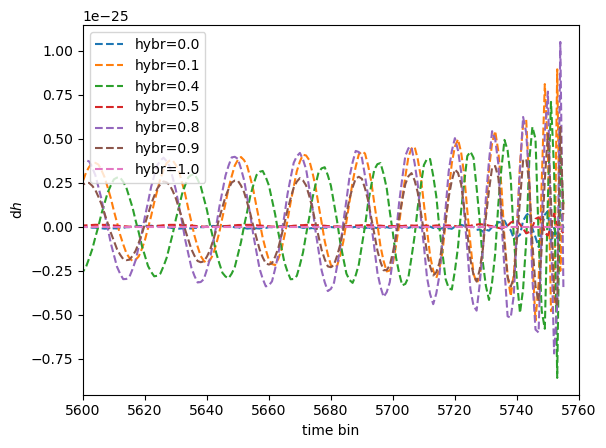

In [131]:
hybr_range = [0.0, 0.1, 0.4, 0.5, 0.8, 0.9, 1.0]


d=0
network_spec_d = [net_true.detectors[d].det_key]
# plt.plot(np.fft.irfft(net_true.detectors[d].hf), label='IMRPhenomXAS')

for h, hybr in enumerate(hybr_range):
    print("hybr: ", hybr)

    inj_params_hyb = inj_params.copy()
    inj_params_hyb['hybr'] = hybr

    net_ap_hyb = gwnet.get_hybrid_network_response(inj_params=inj_params_hyb, f_max=f_highs[binary_i+offset], 
        approximant1=approx1, approximant2=approx2, 
        network_key=net_key, calc_detector_responses=True, calc_derivs=False, calc_fisher=False)
    
    ## set up initial waveforms
    h1 = net_true.detectors[d].hf
    h2 = net_ap_hyb.detectors[d].hf
    Sn = net_ap_hyb.detectors[d].psd
    f = net_ap_hyb.detectors[d].f

    # Limit the time window to precisely search for t_0
    time_arr_d = np.linspace(-0.1, 0.1, 5001)


    # Set up Matched Filter 
    x_t0_re_d = np.zeros(len(time_arr_d))
    x_t0_im_d = np.zeros(len(time_arr_d))

    for i_t in range(len(time_arr_d)):
        t0 = time_arr_d[i_t]
        x_t0_d = 4*(integrate.simpson(h1 * np.conjugate(h2) * np.exp(2*np.pi*1j*f*t0)/ Sn, x=f))
        x_t0_re_d[i_t] = np.real(x_t0_d)
        x_t0_im_d[i_t] = np.imag(x_t0_d)

    # Find time that maximizes overlap
    max_idx = np.argmax(x_t0_re_d**2 + x_t0_im_d**2)
    time_shift_d = time_arr_d[max_idx]
    phase_shift_d = np.unwrap(np.angle(x_t0_re_d + 1j*x_t0_im_d))[max_idx]

    inj_params_opt_d = inj_params_hyb.copy()
    inj_params_opt_d['tc'] = time_shift_d
    inj_params_opt_d['phic'] = phase_shift_d 
    net_tr_opt_d = gwnet.get_network_response(inj_params=inj_params_opt_d, f_max=f_highs[binary_i+offset], 
    approximant=approx1,
    network_spec=network_spec_d, calc_detector_responses=True, calc_derivs=False, calc_fisher=False)    

#  ## Sanity Checks to make sure the correct phase and time shifts are being applied
    # plt.title(network_spec_d)
    # plt.plot(time_arr_d, x_t0_re_d**2 + x_t0_im_d**2)
    # plt.axvline(x=time_shift_d, ls='--', c='r')
    # plt.xlabel('$t_0$ [s]')
    # plt.ylabel("$x(t_0)$")
    # plt.loglog()
    # plt.xlim(1e-3, 1e0)
    # plt.show()
    # print("time shift:", time_shift_d)
    # print("phase shift:", phase_shift_d)
    # print("Inner product:")
    # print(inner_prod_simps_normed(net_tr_opt_d.detectors[0].hf, h2, Sn, f))

    plt.plot(np.fft.irfft(net_tr_opt_d.detectors[0].hf) - np.fft.irfft(net_ap_hyb.detectors[0].hf),  ls='--', label=f'hybr={hybr}')

plt.xlabel('time bin')
plt.ylabel('d$h$')
plt.legend()
plt.xlim(5600, 5760)
plt.show()

